# VAE

In [2]:
# imports
import sys
import os
dir_path = os.path.dirname(os.path.realpath(__file__))
sys.path.append( os.path.join( dir_path, '../..' ))

from skripts.FIA.FIA import *
from skripts.ML.ML4com import *
from skripts.helpers.pc_stats import *

import keras
from keras.layers import Input, Dense, Lambda
from keras.layers import BatchNormalization, Dropout, LeakyReLU
from keras.models import Model
from keras.losses import mse
from keras.optimizers import Adam, Nadam     # Nadam should converge better
from keras import activations, layers
from keras import backend

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import keras_tuner
from keras_tuner.tuners import Hyperband, BayesianOptimization

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

NameError: name '__file__' is not defined

In [2]:
info_dir = "../../data/comm8_self"
data_dir = "../../runs/FIA/comm8/oms"
run_dir = "../../runs/ML/try"

info_dir = os.path.normpath(os.path.join(os.getcwd(), info_dir))
data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

strains = pd.read_csv(os.path.join(info_dir, "strains.tsv"), sep="\t")
comm8 = pd.read_csv(os.path.join(info_dir, "comm8.tsv"), sep="\t")

fia_df = load_fia_df(data_dir, file_ending=".mzML", separator="\t")

Loading names:


100%|██████████| 72/72 [00:00<?, ?it/s]


Loading experiments:


100%|██████████| 68/68 [00:00<00:00, 96.07it/s] 


In [3]:
# binned_dfs = bin_df_stepwise_batch(fia_df, binning_var="mz", binned_var="inty", statistic="sum", start=50.0, stop=1700.0, step=0.002)
# binned_dfs.to_csv(os.path.join(run_dir, "data_matrix.tsv"), sep="\t")
binned_dfs = pd.read_csv(os.path.join(run_dir, "data_matrix_oms.tsv"), sep="\t", index_col="mz", engine="pyarrow")

In [4]:
binned_dfs[:] =  total_ion_count_normalization(binned_dfs)

In [5]:
print(binned_dfs.shape)
print(comm8.shape)
print(strains.shape)

(825000, 68)
(68, 8)
(8, 1)


## Model

In [6]:
import keras
from keras.layers import Input, Dense, Lambda
from keras.layers import BatchNormalization, Dropout, LeakyReLU
from keras.models import Model
from keras.losses import mse
from keras.optimizers.legacy import Nadam
from keras import activations, layers
from keras import backend

In [7]:
# Data & model configuration
batch_size = 32
no_epochs = 1000
latent_dim = 18

original_dim = binned_dfs.shape[0]
input_shape = (original_dim,)

In [8]:
def sample_z(args):
    """
    Define sampling with reparameterization trick
    """
    mu, sigma = args
    batch     = backend.shape(mu)[0]
    dim       = backend.int_shape(mu)[1]
    eps       = backend.random_normal(shape=(batch, dim))
    return mu + backend.exp(sigma / 2) * eps

def model_builder(hp):   
    # Hyperparameters
    intermediate_neurons        = hp.Int('intermediate_neurons', min_value=100, max_value=10100, step=2000, default=1000)
    intermediate_activation     = hp.Choice(f"intermediate_activation", ["relu", "tanh", "leakyrelu"], default="relu")
    input_dropout               = hp.Float('input_dropout', min_value=0.2, max_value=0.8, sampling='linear', default=0.5)
    intermediate_dropout        = hp.Float('intermediate_dropout', min_value=0.2, max_value=0.8, sampling='linear', default=0.5)
    learning_rate               = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)
    kl_loss_scaler              = hp.Float('kl_beta', min_value=1e-3, max_value=1e1, sampling='log', default=1e-2)

    if intermediate_activation == "leakyrelu":
        intermediate_activation     = layers.LeakyReLU() 

    # Encoder
    i       = Input(shape=input_shape, name='encoder_input')
    enc     = Dropout(input_dropout) (i)      # Dropout for more redundant neurons
    enc     = Dense(intermediate_neurons, activation=intermediate_activation) (i)
    enc     = Dropout(intermediate_dropout) (enc)
    enc     = BatchNormalization() (enc)
    mu      = Dense(latent_dim, name='latent_mu') (enc)
    sigma   = Dense(latent_dim, name='latent_sigma') (enc)
    z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z') ([mu, sigma])  ## Use reparameterization trick

    encoder = Model(i, [mu, sigma, z], name='encoder')  ## Instantiate encoder
    
    # Decoder
    d_i     = Input(shape=(latent_dim, ), name='decoder_input')
    dec     = Dense(intermediate_neurons, activation=intermediate_activation) (d_i) 
    dec     = Dropout(intermediate_dropout) (dec)
    dec     = BatchNormalization() (dec)
    o       = Dense(original_dim) (dec)

    decoder = Model(d_i, o, name='decoder') ## Instantiate decoder
    
    # VAE as a whole
    def kl_reconstruction_loss(true, pred):
        """
        Define loss function 
        """
        reconstruction_loss = mse(true, pred) * original_dim
        kl_loss = -0.5 * backend.sum( 1.0 + sigma - backend.square(mu) - backend.exp(sigma), axis=-1)

        return backend.mean(reconstruction_loss + kl_loss_scaler * kl_loss)

    # Instantiate VAE
    vae_outputs = decoder (encoder(i)[2])
    vae         = Model(i, vae_outputs, name='vae')

    # Define optimizer
    optimizer = Nadam(learning_rate)

    # Compile VAE
    vae.compile(optimizer=optimizer, loss=kl_reconstruction_loss, metrics = ['mse'])
    
    return vae

In [9]:
# Set tuner parameters
tuner = Hyperband(
    model_builder,
    objective='mse',
    factor=4,
    max_epochs=1000,
    directory='../../runs/VAE/hyperband_optimization',
    project_name='mtvae_nadam_dropout')


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
intermediate_neurons (Int)
{'default': 1000, 'conditions': [], 'min_value': 100, 'max_value': 10100, 'step': 2000, 'sampling': 'linear'}
intermediate_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'leakyrelu'], 'ordered': False}
input_dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.2, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}
intermediate_dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.2, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
kl_beta (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.001, 'max_value': 10.0, 'step': None, 'sampling': 'log'}


In [11]:
X = binned_dfs.transpose()
ys = comm8
kf = KFold(n_splits = 5, shuffle=True)     # stratified: skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

training_data, test_data, training_labels, test_labels = train_test_split(X, ys, test_size=0.2, random_state=42)

In [12]:
tuner.search(training_data, training_data, validation_data = (test_data, test_data))          # ~2h runtime
send_mail(subject="VAE Tuning", message=f"\nHyperparameter search finished:\n{tuner.get_best_hyperparameters(num_trials = 1)[0]}")

Trial 2 Complete [00h 03m 40s]

Best mse So Far: None
Total elapsed time: 00h 04m 51s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
4100              |8100              |intermediate_neurons
relu              |leakyrelu         |intermediate_activation
0.2047            |0.44573           |input_dropout
0.38404           |0.7922            |intermediate_dropout
0.0039796         |0.0093584         |learning_rate
0.35006           |0.073057          |kl_beta
4                 |4                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Train on 54 samples, validate on 14 samples
Epoch 1/4


Traceback (most recent call last):
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py", line 856, in fit
    return func.fit(
           ^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_arrays_v1.py", line 734, in fit
    return fit_loop(
           ^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_arrays_v1.py", line 421, in model_iteration
    batch_outs = f(ins_batch)
                 ^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\backend.py", line 4607, in __call__
    fetched = self._callable_fn(*array_vals, run_metadata=self.run_metadata)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\tensorflow\python\client\session.py", line 1505, in __call__
    ret = tf_session.TF_SessionRunCallable(self._session._session,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[4100,825000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node training/Nadam/Nadam/update_dense_2/kernel/mul_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.



## Return best

In [ ]:
tuner.results_summary(num_trials = 1)

Results summary
Results in ../../runs/VAE/hyperband_optimization\mtvae_nadam_thight_search
Showing 1 best trials
Objective(name="mse", direction="min")

Trial 0174 summary
Hyperparameters:
encoder_units: 180
decoder_units: 20
learning_rate: 0.001282973471073738
kl_beta: 0.00542722971087829
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 9.425958680253643e-09


In [ ]:
tuner.get_best_models()[0].summary()



Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 825000)]          0         
                                                                 
 encoder (Functional)        [(None, 18),              148506696 
                              (None, 18),                        
                              (None, 18)]                        
                                                                 
 decoder (Functional)        (None, 825000)            17325380  
                                                                 
Total params: 165832076 (632.60 MB)
Trainable params: 165832076 (632.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(best_hps.get('encoder_units'))
print(best_hps.get('decoder_units'))
print(best_hps.get('learning_rate'))
print(best_hps.get('kl_beta'))

180
20
0.001282973471073738
0.00542722971087829


## Training

In [ ]:
sys.path.append( '../../../mtVAE' )
from models import *
from metric_functions import *

In [ ]:
from VAE import *

In [ ]:
# Data & model configuration
input_dim = original_dim
intermediate_dim = 200
latent_dim = 20

kl_beta = 5e-3
learning_rate = 1e-3

batch_size = 32
n_epochs = 1000

save_folder = '../../runs/VAE'


# instantiate model
mtmodel = mtVAE(input_dim, intermediate_dim, latent_dim,
                kl_beta, learning_rate,
                intermediate_dropout=0.5, input_dropout=0.5,
                intermediate_activation=LeakyReLU())

In [ ]:
# Train model
history = mtmodel.train(training_data, test_data, n_epochs, batch_size)       # Changes: Nadam optimizer



Train on 54 samples, validate on 14 samples
Epoch 1/1000
54/54 - 3s - loss: 87.5143 - mse: 1.0608e-04 - val_loss: 68.9895 - val_mse: 8.3624e-05 - 3s/epoch - 53ms/sample
Epoch 2/1000


c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


54/54 - 3s - loss: 81.1043 - mse: 9.8308e-05 - val_loss: 31.2087 - val_mse: 3.7829e-05 - 3s/epoch - 50ms/sample
Epoch 3/1000
54/54 - 3s - loss: 32.9100 - mse: 3.9891e-05 - val_loss: 58.0021 - val_mse: 7.0306e-05 - 3s/epoch - 49ms/sample
Epoch 4/1000
54/54 - 3s - loss: 38.4987 - mse: 4.6665e-05 - val_loss: 47.8762 - val_mse: 5.8032e-05 - 3s/epoch - 49ms/sample
Epoch 5/1000
54/54 - 3s - loss: 20.8088 - mse: 2.5223e-05 - val_loss: 11.9760 - val_mse: 1.4516e-05 - 3s/epoch - 50ms/sample
Epoch 6/1000
54/54 - 3s - loss: 10.2900 - mse: 1.2473e-05 - val_loss: 10.4109 - val_mse: 1.2619e-05 - 3s/epoch - 51ms/sample
Epoch 7/1000
54/54 - 3s - loss: 11.2972 - mse: 1.3694e-05 - val_loss: 20.9386 - val_mse: 2.5380e-05 - 3s/epoch - 52ms/sample
Epoch 8/1000
54/54 - 3s - loss: 26.4785 - mse: 3.2095e-05 - val_loss: 38.1078 - val_mse: 4.6191e-05 - 3s/epoch - 53ms/sample
Epoch 9/1000
54/54 - 3s - loss: 25.3360 - mse: 3.0710e-05 - val_loss: 12.8692 - val_mse: 1.5599e-05 - 3s/epoch - 50ms/sample
Epoch 10/1000

In [ ]:
# Save model
mtmodel.save_model(save_folder)

c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
reconstructed_data = mtmodel.reconstruct(test_data)

c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
plot_df = pd.DataFrame(reconstructed_data.clip(min=0)[0], index=binned_dfs.index, columns=["inty"]).reset_index()
plot_df

,mz,inty
0,50.001,0.000000
1,50.003,0.000082
2,50.005,0.000008
3,50.007,0.000002
4,50.009,0.000000
...,...,...
824995,1699.991,0.000000
824996,1699.993,0.000000
824997,1699.995,0.000000
824998,1699.997,0.000000


In [ ]:
plot_df_2 = pd.DataFrame(test_data.iloc[0].values, index=binned_dfs.index, columns=["inty"]).reset_index()
plot_df_2

,mz,inty
0,50.001,0.0
1,50.003,0.0
2,50.005,0.0
3,50.007,0.0
4,50.009,0.0
...,...,...
824995,1699.991,0.0
824996,1699.993,0.0
824997,1699.995,0.0
824998,1699.997,0.0


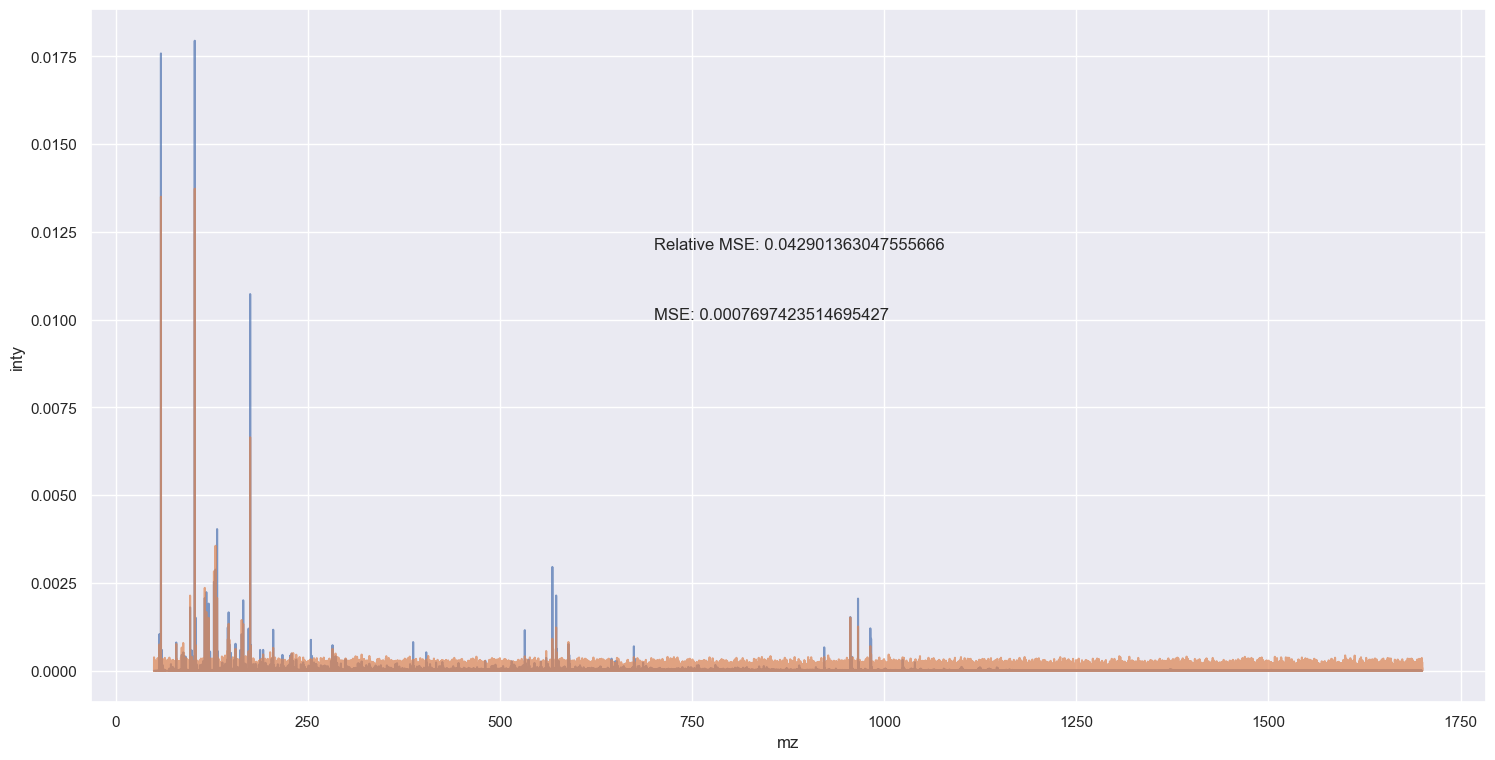

In [ ]:
mse = np.mean(np.sum((plot_df_2["inty"] - plot_df["inty"])**2))
rel_mse = mse / np.max(plot_df_2["inty"])

ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.text(700, 0.01, f"MSE: {mse}")
plt.text(700, 0.012, f"Relative MSE: {rel_mse}")
plt.show()

(-0.0001, 0.003)

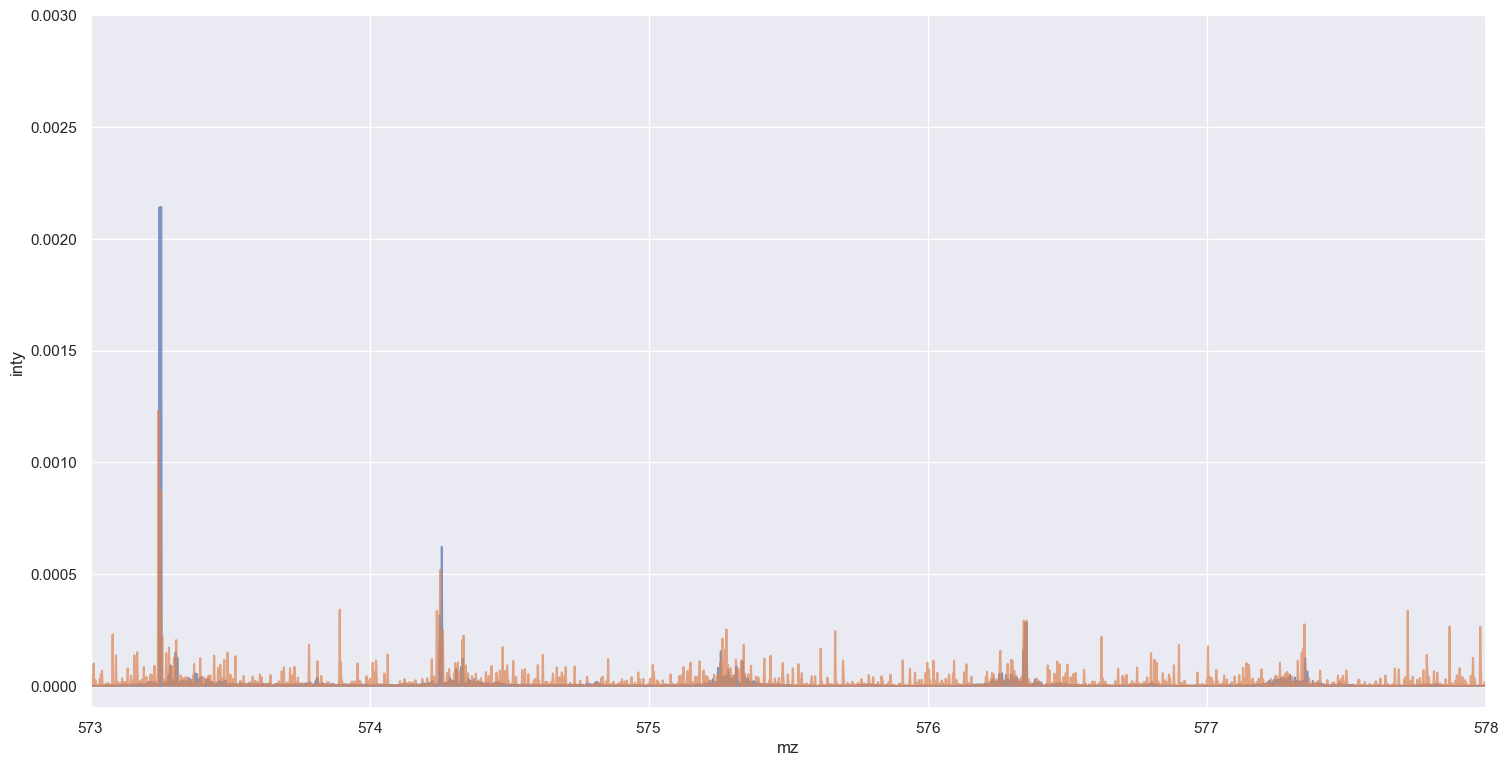

In [ ]:
sns.set(rc={"figure.figsize":(18, 9)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

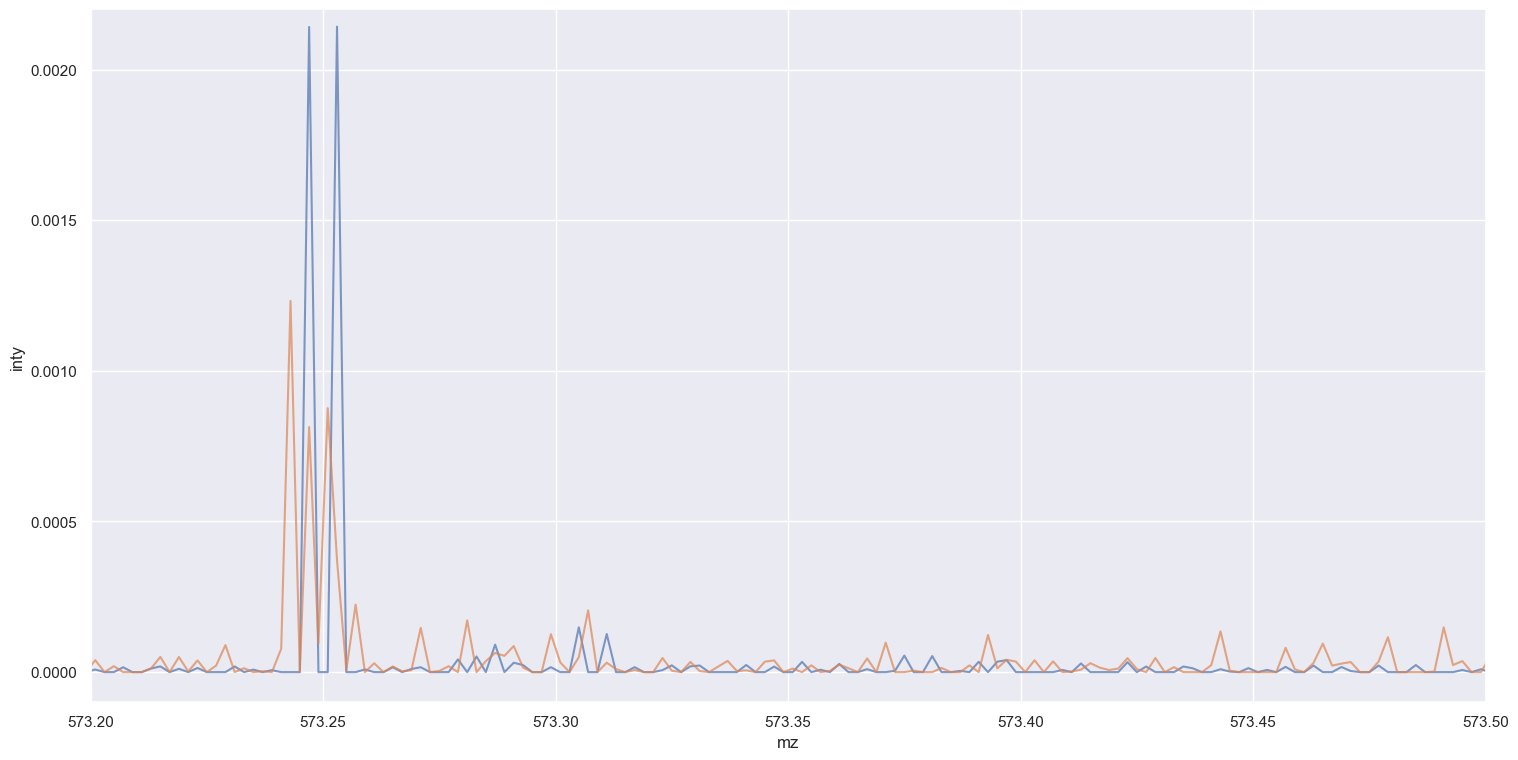

In [ ]:
sns.set(rc={"figure.figsize":(18, 9)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

## Classification

In [ ]:
# Load matrices
strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")

In [ ]:
vae_enc = mtmodel.encode_mu(X)
vae_enc = pd.DataFrame(vae_enc)
vae_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.040587,-0.184386,0.186828,0.178457,0.104944,0.323250,0.001226,0.100432,0.167224,-0.362768,-0.029526,0.175242,0.076567,-0.166418,0.162517,-0.237154,-0.054643,0.212377,-0.114535,-0.008502
1,-0.042219,-0.186205,0.186309,0.179352,0.103276,0.323463,0.000774,0.100708,0.167397,-0.362725,-0.029135,0.174520,0.076391,-0.167263,0.162701,-0.236665,-0.054667,0.213280,-0.113130,-0.008329
2,-0.039721,-0.182793,0.183115,0.177548,0.101912,0.317924,-0.000246,0.100371,0.164644,-0.357129,-0.030553,0.174054,0.077742,-0.162382,0.162453,-0.234839,-0.053447,0.209512,-0.113043,-0.007733
3,-0.041061,-0.185449,0.187599,0.178005,0.105359,0.324202,0.001432,0.099781,0.168674,-0.364253,-0.029961,0.175288,0.076527,-0.165382,0.162212,-0.238606,-0.054351,0.211943,-0.114262,-0.010218
4,-0.040675,-0.183967,0.186178,0.177980,0.104538,0.322031,0.001237,0.100191,0.166761,-0.361580,-0.029428,0.174614,0.076446,-0.165869,0.162073,-0.236529,-0.054455,0.211660,-0.114074,-0.008538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.041592,-0.186487,0.189693,0.179270,0.103745,0.324505,0.003021,0.100621,0.167529,-0.364951,-0.029451,0.176775,0.076843,-0.168174,0.161341,-0.237823,-0.054451,0.213257,-0.114875,-0.008866
64,-0.043291,-0.186846,0.186274,0.176963,0.105697,0.325417,0.001617,0.098610,0.169118,-0.362662,-0.029590,0.175303,0.075180,-0.164818,0.162999,-0.238674,-0.055341,0.209760,-0.112030,-0.008592
65,-0.040760,-0.183984,0.186283,0.177985,0.104601,0.322057,0.001358,0.100242,0.166779,-0.361683,-0.029522,0.174648,0.076484,-0.165901,0.161995,-0.236490,-0.054428,0.211720,-0.114052,-0.008544
66,-0.039782,-0.181248,0.187935,0.175375,0.106807,0.320874,-0.000416,0.098744,0.166897,-0.364459,-0.030205,0.175222,0.077733,-0.163980,0.160756,-0.238355,-0.055411,0.213546,-0.118463,-0.010409


In [ ]:
from sklearn.model_selection import KFold
X = vae_enc
ys = comm8
cv = 5
kf = KFold(n_splits = cv, shuffle=True)

In [ ]:
def build_model(hyperparameters):
    model = keras.Sequential(name="MS_community_classifier")
    model.add(layers.InputLayer(input_shape=(X.shape[1],)))
    if hyperparameters.Boolean("dropout_in"):
        model.add(keras.layers.Dropout(0.5, noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())
    
    for i in range(hyperparameters.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hyperparameters.Int(f"units_{i}", min_value=32, max_value=256, step=64),
                activation=hyperparameters.Choice("activation", ["relu", "tanh"]),
            )
        )    
    if hyperparameters.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.25, noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())

    model.add(layers.Dense(1,  activation=activations.sigmoid))
    
    loss_function = keras.losses.BinaryCrossentropy()

    learning_rate = hyperparameters.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = keras.optimizers.legacy.Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    return model

In [ ]:
hp = keras_tuner.HyperParameters()
hp.Fixed("dropout", True)
hp.Fixed("num_layers", 1)
hp.Fixed("units_1", 64)
hp.Fixed("activation", "relu")
hp.Fixed("lr", 1e-3)

In [ ]:
confusion_matrices = []
accuracies = []

for y in tqdm(ys.columns):
	y = ys[y]
	conf_mats = []
	acc = []
	for train_index, val_index in kf.split(X, y):
		class_model = build_model(hp)
		training_data = X.iloc[train_index]
		training_labels = y.iloc[train_index]
		validation_data = X.iloc[val_index]
		validation_labels = y.iloc[val_index]
		
		callback = keras.callbacks.EarlyStopping(monitor='loss', patience=100)	# Model will stop when no improvment is reached after 1000 epochs
		history = class_model.fit(training_data, training_labels, epochs=1000, verbose=0, callbacks=[callback])

		val_loss, val_acc = class_model.evaluate(validation_data,  validation_labels, verbose="auto")
		acc.append(val_acc)
		prediction = class_model.predict(validation_data)
		prediction = [0.0 if pred[0] < 0.5 else 1.0 for pred in prediction]
		conf_mats.append(confusion_matrix(validation_labels,  prediction))

	accuracies.append(acc)
	confusion_matrices.append(np.sum(conf_mats, axis=0))

  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.

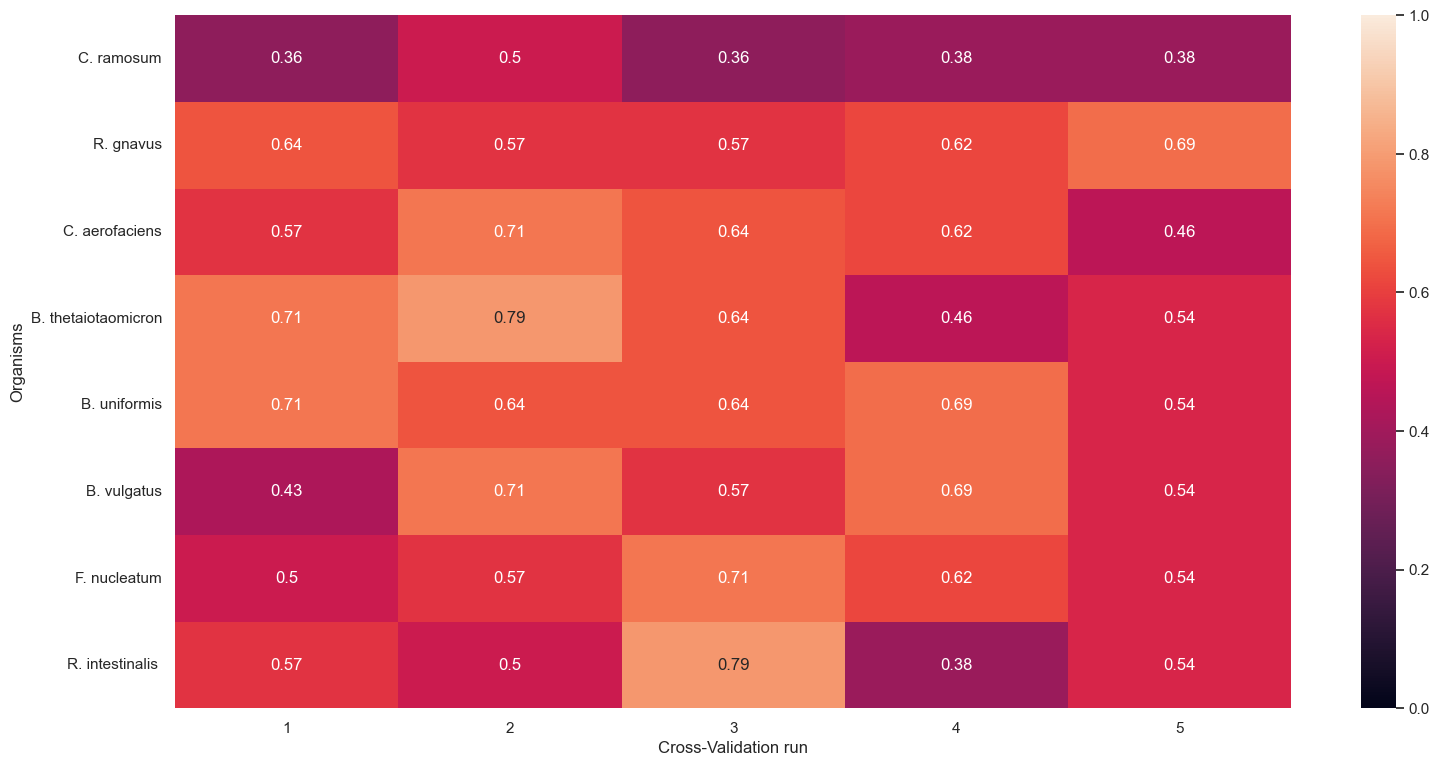

In [ ]:
# Accuracy CV matrix
plot_df = pd.DataFrame(accuracies, columns=range(1,cv+1), index=strains["0"])
plot_df.index.name = "Organisms"
plot_df.columns.name = "Cross-Validation run"
ax = sns.heatmap(plot_df, vmin=0, vmax=1.0, annot=True)

In [ ]:
plot_cv_confmat(ys=ys, target_labels=strains.values, accuracies=np.mean(accuracies, axis=1), confusion_matrices=confusion_matrices,
				outdir="../../runs/ML/try/NN", name="VAE-64(0.5)ReLU-LR0.001,1000epochs.png")